# Goodwin's oscillator toy model

This example shows how the Goodwin's Oscillator toy model can be used.

This model has five parameters, and three oscillating states.

In [1]:
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np

model = pints.toy.GoodwinOscillatorModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
real_parameters = model.suggested_parameters()
print(real_parameters)

[ 2.    4.    0.12  0.08  0.1 ]


In the same way, we can get a suggested set of sampling times:

In [3]:
times = model.suggested_times()

Now we can run a simulation:

In [4]:
values = model.simulate(real_parameters, times)

This gives us all we need to create a plot of current versus time:

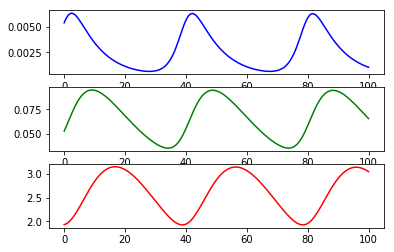

In [5]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, values[:, 2], 'r')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

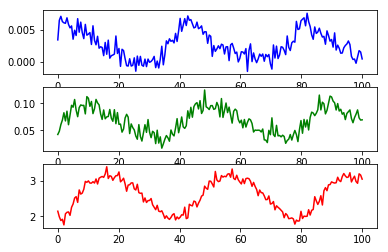

In [6]:
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

Now we can try and infer the original parameters:

In [7]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Done!


Now we can inspect the resulting chains:

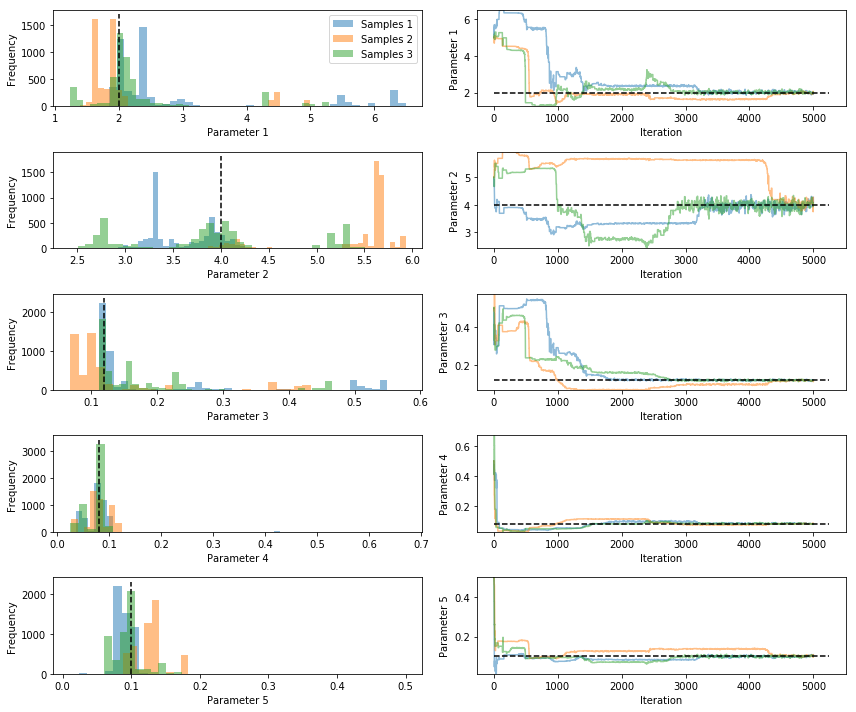

In [8]:
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

This is a pretty hard problem!

And what about optimisation?

In [9]:
# Fit to the noisy data
parameters = []
opt = pints.Optimisation(log_posterior, x0[0], method=pints.XNES)
opt.set_log_to_screen(False)
parameters, fbest = opt.run()

print('')
print('            p1       p2       p3       p4       p5')
print('real  ' + ' '.join(['{: 8.4g}'.format(float(x)) for x in real_parameters]))
print('found ' + ' '.join(['{: 8.4g}'.format(x) for x in parameters]))


            p1       p2       p3       p4       p5
real         2        4     0.12     0.08      0.1
found    1.999    4.002     0.12  0.07998      0.1
